# Basic Plots

This notebook focuses on using the matplotlib Python library to visualize data from BTrDB.  These examples are intended as a guide for creating your own basic plots for data analysis.

**NOTE**: To get access to the Sunshine dataset to run this notebook, please register for an API key at [ni4ai.org](https://ni4ai.org/).

## Notebook Setup

### Imports

In [1]:
%matplotlib inline 

import btrdb
import numpy as np
import matplotlib.pyplot as plt
import yaml

from btrdb.utils.timez import ns_delta, ns_to_datetime

**NOTE**: The use of `%matplotlib inline` is required on Jupyter lab.

### Connect to Server

In [2]:
# Make sure you add your API key to the config file to connect!
with open('../config.yaml', 'r') as f:
    config = yaml.safe_load(f)
    
conn = btrdb.connect(config['connection']['api_url'], config['connection']['api_key'])
conn.info()

{'majorVersion': 5, 'build': '5.11.124', 'proxy': {'proxyEndpoints': []}}

### Convenience Functions

In [3]:
def split_points(points):
    """
    This helper function takes in RawPoints and returns two
    np.arrays, one for the time index and the other for the 
    values; this makes plotting with matplotlib much easier.
    """
    # Convert times to datetimes for better x-axis ticks
    times = np.array([ns_to_datetime(p.time) for p in points])
    values = np.array([p.value for p in points])
    return times, values

## Basic Time Series Plot

Let's begin by just rendering a basic plot of one of the streams in our dataset. For visualization inside of a notebook it is highly recommended that you put the code into a function -- this helps encapsulate the `pyplot` directives that operate on a global figure and axes. 

In [4]:
def simple_plot(stream, start, end, color=None):
    # Get data and split into time and values arrays.
    points = [p for p, version in stream.values(start, end)]
    times, values = split_points(points)
    
    # Create a new figure and axes that is 10 by 6 inches.
    _, ax = plt.subplots(figsize=(10,6))
    
    # Plot the time series with the specified color and label
    ax.plot(times, values, color=color, label=stream.name)
    
    # Modify the plot by adding axis labels and a legend
    ax.set_xlabel("time")
    ax.set_ylabel(stream.tags()['unit'])
    ax.legend()
    
    # Always return the ax to ensure proper rendering
    return ax

We can make use of this simple function by fetching a stream then defining a 10 minute window of data to view, before passing that data to our plotting function.

Here, we'll use data for one of the streams in the `Sunshine` dataset.

In [5]:
stream = conn.stream_from_uuid("35bdb8dc-bf18-4523-85ca-8ebe384bd9b5")
stream.annotations()

({'location': 'PV array',
  'impedance': {'source': 'PMU3',
   'target': 'PMU1',
   'Zreal': '[[0.523+1.135j, 0.146+0.387j, 0.146+0.387j], [0.146+0.387j, 0.523+1.135j, 0.146+0.387j], [0.146+0.387j, 0.146+0.387j, 0.523+1.135j]]'}},
 1)

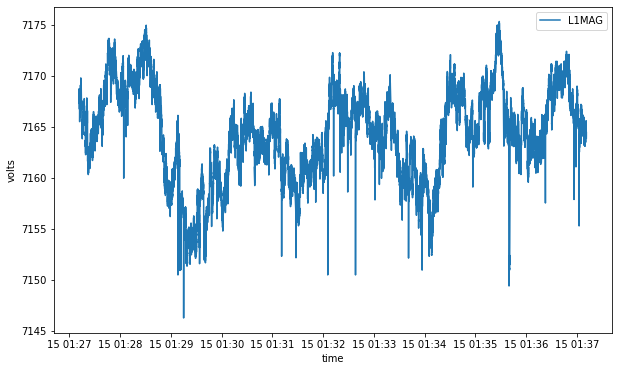

In [6]:
latest, _ = stream.latest()

end = latest.time
start = end - ns_delta(minutes=10)

_ = simple_plot(stream, start, end)

This simple plot is a good start to visualizing time series streams, but is lacking some functionality: for example, what if we want to plot multiple streams? Can we make the x-axis ticks more informative with time? Can we set the units of the y-axis? What about a title? We'll tackle these questions in the next couple of sections. 

Before we get to that, it is important to note the importance of `return ax` in our `simple_plot` function. It allows you to directly modify the Axes after calling the utility function, giving a lot of flexibility when defining helper functions and using them in code:

Text(0, 0.5, 'L1Mag (Volts)')

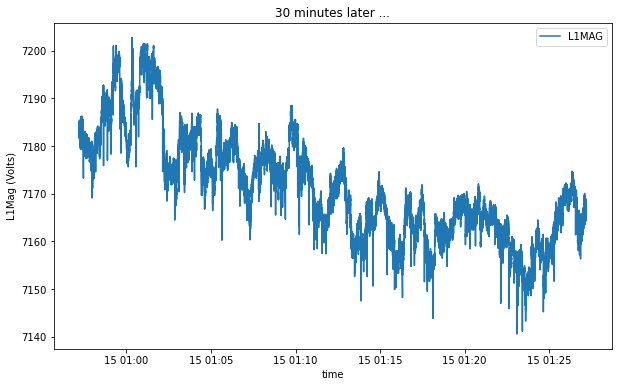

In [7]:
time_window = 30 # minutes
start2 = start - ns_delta(minutes=time_window)
end2 = start - ns_delta(seconds=0)

ax = simple_plot(stream, start2, end2)
ax.set_title("%i minutes later ..."%(time_window))
ax.set_ylabel('%s (%s)'%(stream.name.title(), stream.unit.title()))

## Multiple Streams Plot

Let's see how easy it is to use matplotlib to plot for multiple streams.  We will create a function that accepts a sequence of streams along with a start and end for the plot.  Note that our example is assuming that all of the streams share the same Y axis and use the same unit (volts vs amps, etc.).

In [8]:
def multiple_plot(streams, start, end):
    # Create a new figure and axes to draw on
    _, ax = plt.subplots(figsize=(10,6))
    
    # Loop through all streams and plot for the specified time range
    for s in streams:
        points = [p for p, version in s.values(start, end)]
        times, values = split_points(points)
        ax.plot(times, values, label=s.name)

    ax.set_xlabel("time")
    ax.set_ylabel(s.tags()['unit'])
    ax.legend()
    
    return ax

### Plot List of Streams

Now let's use our plotting function to plot a list of Stream objects.

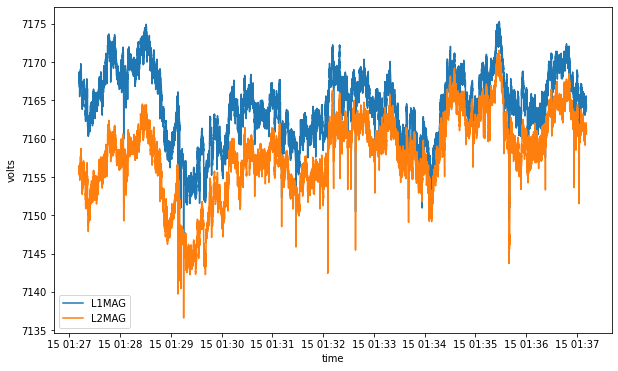

In [9]:
stream1 = conn.stream_from_uuid("35bdb8dc-bf18-4523-85ca-8ebe384bd9b5")
stream2 = conn.stream_from_uuid("d4cfa9a6-e11a-4370-9eda-16e80773ce8c")
streams = [stream1, stream2]

latest, _ = stream1.latest()
end = latest.time
start = end - ns_delta(minutes=10)

_ = multiple_plot(streams, start, end)

### Plot StreamSet

Because a StreamSet supports iteration, we can use almost exactly the same code to plot all of the streams in a StreamSet object.

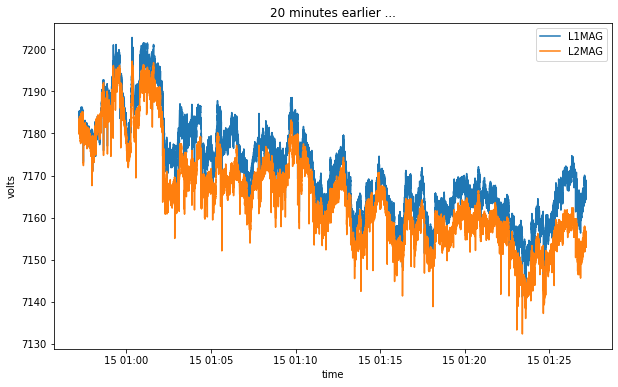

In [10]:
streams = conn.streams("35bdb8dc-bf18-4523-85ca-8ebe384bd9b5", "d4cfa9a6-e11a-4370-9eda-16e80773ce8c")

latest, _ = stream1.latest()
end = latest.time - ns_delta(minutes=10)
start = end - ns_delta(minutes=30)

ax = multiple_plot(streams, start2, end2)
_ = ax.set_title("20 minutes earlier ...")